In [37]:
import os
import zipfile

In [39]:
base_dir = 'C:\\Users\\tejal\\Downloads\\Positive and Negative\\'
train_dir = os.path.join(base_dir, 'Train')
train_positive_dir = os.path.join(train_dir, 'Positive')
train_negative_dir = os.path.join(train_dir, 'Negative')
validation_dir_root = os.path.join(base_dir, 'Validation')
validation_dir_pos = os.path.join(validation_dir_root, 'Positive')
validation_dir_neg = os.path.join(validation_dir_root, 'Negative')
test_dir = os.path.join(base_dir, 'Testing')
print(validation_dir_pos)

C:\Users\tejal\Downloads\Positive and Negative\Validation\Positive


In [9]:
train_positive_fnames = os.listdir(train_positive_dir)
train_negative_fnames = os.listdir(train_negative_dir)
#print(train_positive_fnames[:10])
print('Total training positive images         :', len(os.listdir(train_positive_dir)))
print('Total training negative images         :', len(os.listdir(train_negative_dir)))
print('Total positive validation test images  :', len(os.listdir(validation_dir_pos)))
print('Total Negative validation test images  :', len(os.listdir(validation_dir_neg)))
print('Total Test data images                 :', len(os.listdir(os.path.join(test_dir, 'Test'))))

Total training positive images         : 370
Total training negative images         : 188
Total positive validation test images  : 40
Total Negative validation test images  : 26
Total Test data images                 : 256


In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

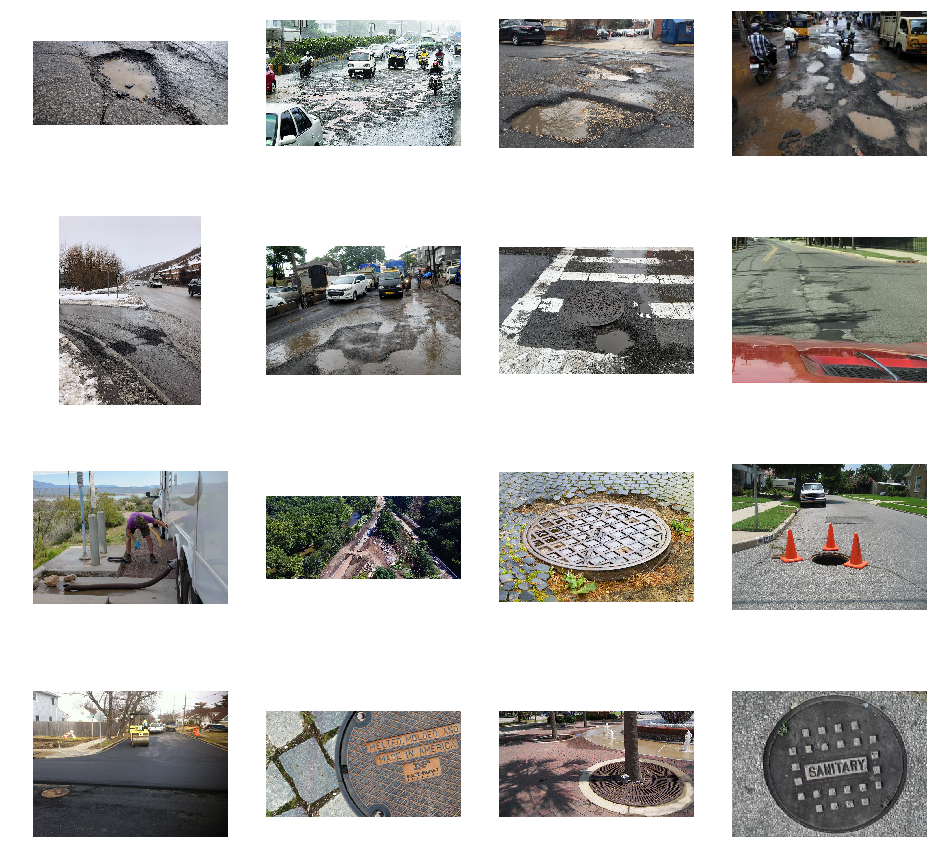

In [41]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_pos_pix = [os.path.join(train_positive_dir, fname) 
                for fname in train_positive_fnames[pic_index-8:pic_index]]
next_neg_pix = [os.path.join(train_negative_dir, fname) 
                for fname in train_negative_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_pos_pix+next_neg_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [42]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [43]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [44]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
__________

In [46]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print(train_positive_dir)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=1,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir_root,
        target_size=(150, 150),
        batch_size=1,
        class_mode='binary')

C:\Users\tejal\Downloads\Positive and Negative\Train\Positive
Found 555 images belonging to 2 classes.
Found 65 images belonging to 2 classes.


In [49]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [56]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  # 2000 images = batch_size * steps
      epochs=6,
      validation_data=validation_generator,
      validation_steps=3,  # 1000 images = batch_size * steps
      verbose=1
      )

Epoch 1/6
8/8 [==============================] - 2s 233ms/step - loss: 5.9784 - acc: 0.6250 - val_loss: 5.3141 - val_acc: 0.6667
Epoch 2/6
8/8 [==============================] - 2s 267ms/step - loss: 9.9640 - acc: 0.3750 - val_loss: 5.3141 - val_acc: 0.6667
Epoch 3/6
8/8 [==============================] - 2s 189ms/step - loss: 3.9856 - acc: 0.7500 - val_loss: 5.3141 - val_acc: 0.6667
Epoch 4/6
8/8 [==============================] - 1s 175ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 5.3141 - val_acc: 0.6667
Epoch 5/6
8/8 [==============================] - 1s 187ms/step - loss: 3.9856 - acc: 0.7500 - val_loss: 5.3141 - val_acc: 0.6667
Epoch 6/6
8/8 [==============================] - 2s 203ms/step - loss: 5.9784 - acc: 0.6250 - val_loss: 5.3141 - val_acc: 0.6667


C:\Users\tejal\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


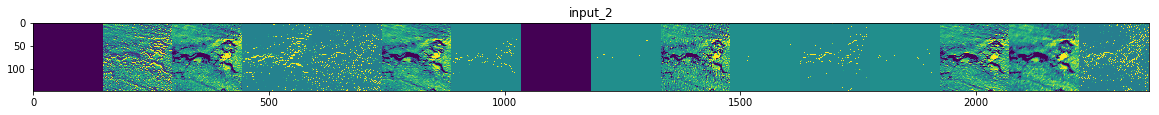

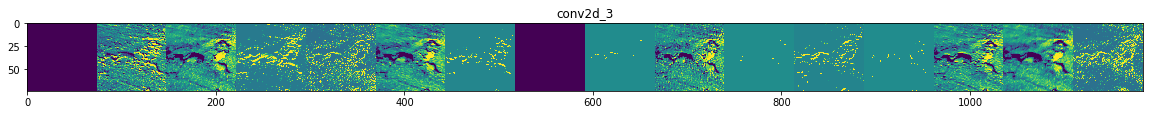

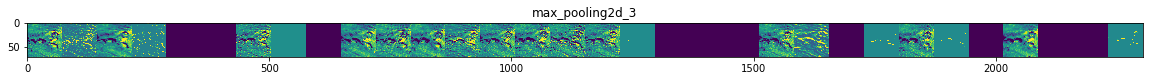

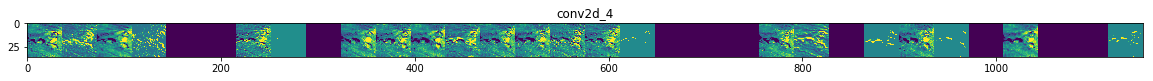

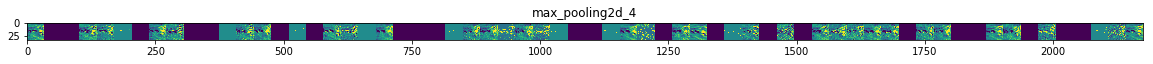

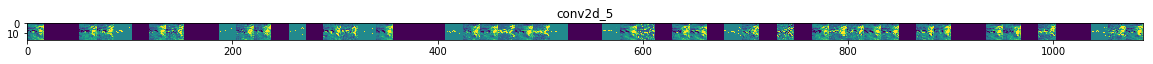

In [53]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
pos_img_files = [os.path.join(train_positive_dir, f) for f in train_positive_fnames]
neg_img_files = [os.path.join(train_negative_dir, f) for f in train_negative_fnames]
img_path = random.choice(pos_img_files + neg_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Text(0.5,1,'Training and Test loss')

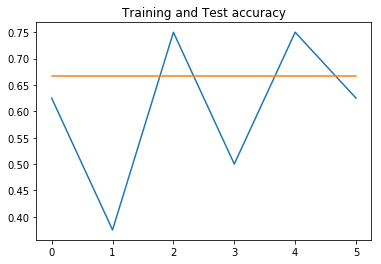

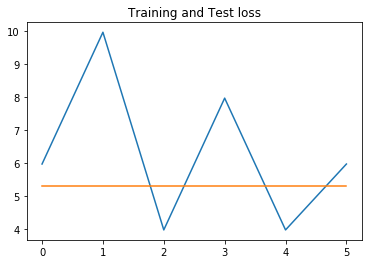

In [57]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and Test accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and Test loss')

(1, 150, 150, 3)
[[1.]]

	class: pothole


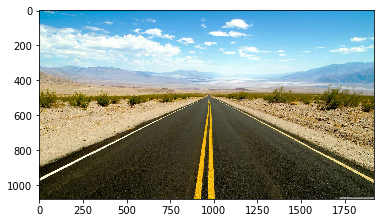

In [58]:
path = os.path.join(test_dir, 'Test/newsEngin.23734282_IMG_3903.jpg')
image = load_img(path, target_size=(150,150))
image_arr = img_to_array(image) # convert from PIL Image to NumPy array
# the dimensions of image should now be (150, 150, 3)

# to be able to pass it through the network and use batches, we want it with shape (1, 150, 150, 3)
image_arr = np.expand_dims(image_arr, axis=0)
print(image_arr.shape)

image_arr /= 255
prediction_array = model.predict(image_arr)
print(prediction_array)
print()
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#testpath = os.path.join(test_dir, 'Test/newsEngin.23734282_IMG_3903.jpg')
#testpath = os.path.join(test_dir, 'Test/xapaz12n7sy4ljforbry.jpg')
#testpath = os.path.join(test_dir, 'Test/potholes-mumbai.jpg')
testpath = os.path.join(test_dir, 'Test/road.jpg')
img = mpimg.imread(testpath)
plt.imshow(img)
if prediction_array[0][0] > 0.3:
    print("\tclass: pothole")
else: 
    print("\tclass: not pothole")

(1, 150, 150, 3)
[[1.]]

	class: not pothole


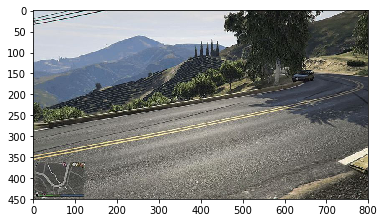

In [60]:
path = os.path.join(test_dir, 'Test/xapaz12n7sy4ljforbry.jpg')
image = load_img(path, target_size=(150,150))
image_arr = img_to_array(image) # convert from PIL Image to NumPy array
# the dimensions of image should now be (150, 150, 3)

# to be able to pass it through the network and use batches, we want it with shape (1, 150, 150, 3)
image_arr = np.expand_dims(image_arr, axis=0)
print(image_arr.shape)

image_arr /= 255
prediction_array = model.predict(image_arr)
print(prediction_array)
print()

testpath = os.path.join(test_dir, 'Test/xapaz12n7sy4ljforbry.jpg')
#testpath = os.path.join(test_dir, 'Test/potholes-mumbai.jpg')
#testpath = os.path.join(test_dir, 'Test/road.jpg')
img = mpimg.imread(testpath)
plt.imshow(img)
if prediction_array[0][0] < 0.3:
    print("\tclass: pothole")
else: 
    print("\tclass: not pothole")

(1, 150, 150, 3)
[[1.]]

	class: pothole


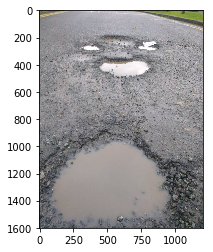

In [33]:
path = os.path.join(test_dir, 'Test/potholes-mumbai.jpg')
image = load_img(path, target_size=(150,150))
image_arr = img_to_array(image) # convert from PIL Image to NumPy array
# the dimensions of image should now be (150, 150, 3)

# to be able to pass it through the network and use batches, we want it with shape (1, 150, 150, 3)
image_arr = np.expand_dims(image_arr, axis=0)
print(image_arr.shape)

image_arr /= 255
prediction_array = model.predict(image_arr)
print(prediction_array)
print()

testpath = os.path.join(test_dir, 'Test/potholes-mumbai.jpg')
#testpath = os.path.join(test_dir, 'Test/road.jpg')
img = mpimg.imread(testpath)
plt.imshow(img)
if prediction_array[0][0] > 0.3:
    print("\tclass: pothole")
else: 
    print("\tclass: not pothole")

(1, 150, 150, 3)
[[1.]]

	class: pothole


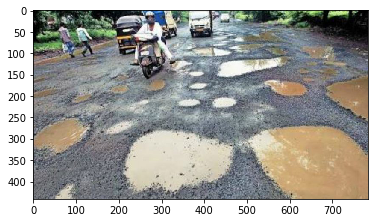

In [61]:
path = os.path.join(test_dir, 'Test/potholes-1-784x441.jpg')
image = load_img(path, target_size=(150,150))
image_arr = img_to_array(image) # convert from PIL Image to NumPy array
# the dimensions of image should now be (150, 150, 3)

# to be able to pass it through the network and use batches, we want it with shape (1, 150, 150, 3)
image_arr = np.expand_dims(image_arr, axis=0)
print(image_arr.shape)

image_arr /= 255
prediction_array = model.predict(image_arr)
print(prediction_array)
print()
testpath = os.path.join(test_dir, 'Test/potholes-1-784x441.jpg')
img = mpimg.imread(testpath)
plt.imshow(img)
if prediction_array[0][0] > 0.3:
    print("\tclass: pothole")
else: 
    print("\tclass: not pothole")